In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
import pandas as pd

Standing = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\lastPrivate\Standing.xlsx')
Standing.columns
Standing = Standing.drop(['Standing'], axis = 1)
Standing.columns

Index(['Standing', 'x', 'y', 'z'], dtype='object')

Index(['x', 'y', 'z'], dtype='object')

In [3]:
# normalize Standing 

G = 9.81
Standing['x'] = Standing['x'].div(G)
Standing['y'] = Standing['y'].div(G)
Standing['z'] = Standing['z'].div(G)

In [4]:
Sitting = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\lastPrivate\Sitting.xlsx')
Sitting.columns
Sitting = Sitting.drop(['Sitting'], axis = 1)
Sitting.columns

Index(['Sitting', 'x', 'y', 'z'], dtype='object')

Index(['x', 'y', 'z'], dtype='object')

In [5]:
# normalize Sitting 

G = 9.81
Sitting['x'] = Sitting['x'].div(G)
Sitting['y'] = Sitting['y'].div(G)
Sitting['z'] = Sitting['z'].div(G)

In [6]:
Jogging = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\lastPrivate\Jogging.xlsx')
Jogging.columns
Jogging = Jogging.drop(['Jogging'], axis = 1)

Index(['Jogging', 'x', 'y', 'z'], dtype='object')

In [7]:
# normalize Jogging 

G = 9.81
Jogging['x'] = Jogging['x'].div(G)
Jogging['y'] = Jogging['y'].div(G)
Jogging['z'] = Jogging['z'].div(G)

In [8]:
Walking = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\lastPrivate\Walking.xlsx')
Walking.columns
Walking = Walking.drop(['Walking'], axis = 1)

Index(['Walking', 'x', 'y', 'z'], dtype='object')

In [9]:
# normalize Walking 

G = 9.81
Walking['x'] = Walking['x'].div(G)
Walking['y'] = Walking['y'].div(G)
Walking['z'] = Walking['z'].div(G)

In [10]:
print(len(Standing))
print(len(Sitting))
print(len(Jogging))
print(len(Walking))

66917
59197
133304
133298


In [11]:
# check nan value
Standing.isnull().sum().sum()
Sitting.isnull().sum().sum()
Jogging.isnull().sum().sum()
Walking.isnull().sum().sum()

0

0

0

0

In [12]:
# Split dataset to 2 parts: Train (60%) - Test (40%)
# 200 samples/frame

window_size = 150
stride = 75 #step

# range (start, stop, step)
X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*0.6), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*0.6), len(Standing), stride)
                                                    if i+window_size<=len(Standing)]

X_sit_train = [Sitting[i:i+window_size] for i in range(0, int(len(Sitting)*0.6), stride)]
X_sit_test = [Sitting[i:i+window_size] for i in range(int(len(Sitting)*0.6), len(Sitting),stride)
                                           if i+window_size<=len(Sitting)]

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*0.6), stride)] 
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*0.6), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_walk_train = [Walking[i:i+window_size] for i in range(0, int(len(Walking)*0.6), stride)] 
X_walk_test = [Walking[i:i+window_size] for i in range(int(len(Walking)*0.6), len(Walking), stride) 
                                            if i+window_size<=len(Walking)]
print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

X_stand_train:  536
X_stand_test:  355
X_sit_train:  474
X_sit_test:  314
X_jog_train:  1067
X_jog_test:  709
X_walk_train:  1067
X_walk_test:  709


In [13]:
# For TRAIN
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
for acts in X_sit_train:
    train_data.append(acts)
    train_label.append(1)
    
for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(3)

print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_sit_test:
    test_data.append(acts)
    test_label.append(1)
        
for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(3)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  3144
train-label length:  3144
test-data length:  2087
test-label length:  2087


In [14]:
def featuresFromBuffer(at):
    feat = np.zeros(15)   
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    #mean
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    #rms
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
    
    # Range
    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range
    
    
    return feat  

In [15]:
# Create features array

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

3144

2087

In [16]:
#Classifier 

from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.944
Accuracy of GBDT classifier on test set: 0.444


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.901
Accuracy of Decision Tree classifier on test set: 0.590


SVM:
Accuracy on training set: 0.92
Accuracy on test set: 0.34


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.440


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.48


<Figure size 560x400 with 0 Axes>

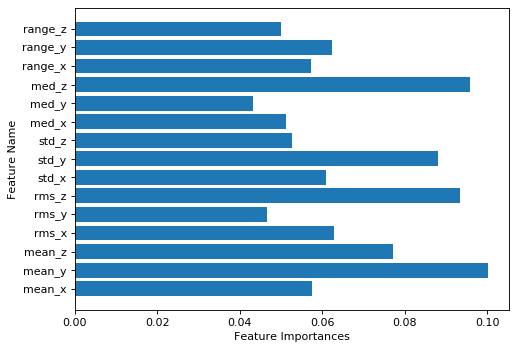

Feature importances: [0.05763592 0.10024133 0.07729848 0.06281228 0.04653164 0.09333607
 0.06098033 0.08806963 0.05280591 0.05124442 0.04324714 0.09596048
 0.05737636 0.06242152 0.05003849]


In [17]:
# adspy_shared_utilities import plot_feature_importances

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'med_x', 'med_y', 'med_z',
                'range_x','range_y','range_z']#'diffState']

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature Importances")
    plt.ylabel("Feature Name")
    plt.yticks(np.arange(c_features), feature_names)
    
plt.figure(figsize=(7,5), dpi=80)
plot_feature_importances(clf4, feature_names)
plt.show()

print('Feature importances: {}'.format(clf4.feature_importances_))

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
      
y_pred = clf4.predict(test_features)

print('micro')
f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro',labels=np.unique(y_pred))

#overall measurement
print('macro')
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro',labels=np.unique(y_pred))

micro


0.4403449928126497

0.4403449928126497

0.4403449928126497

macro


0.4410564401558871

0.4792553367151604

0.4475384998456452

Confusion matrix, without normalization
[[232 121   1   1]
 [146 166   2   0]
 [  1   1  94 613]
 [ 17 118 147 427]]
Normalized confusion matrix
[[0.65 0.34 0.   0.  ]
 [0.46 0.53 0.01 0.  ]
 [0.   0.   0.13 0.86]
 [0.02 0.17 0.21 0.6 ]]


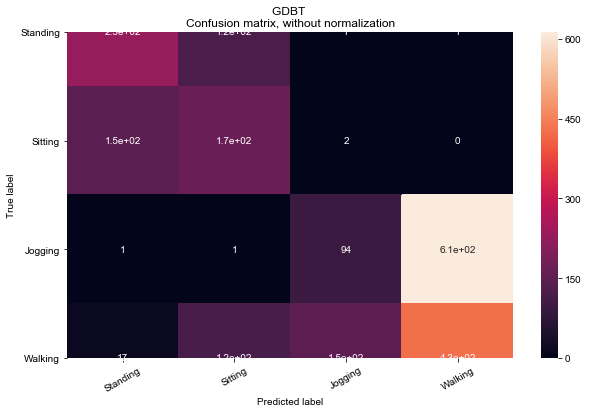

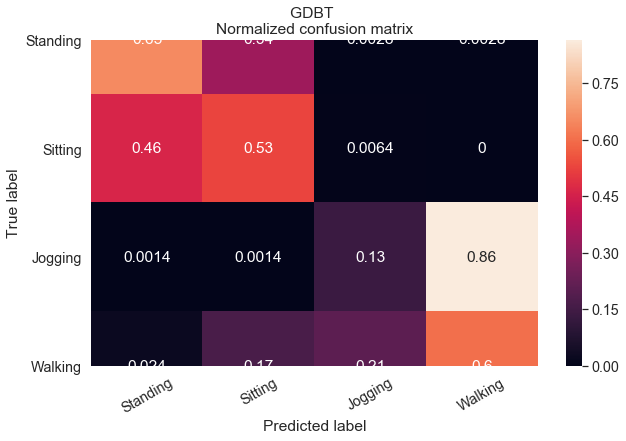


Classification Report: 
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       355
           1       0.41      0.53      0.46       314
           2       0.39      0.13      0.20       709
           3       0.41      0.60      0.49       709

    accuracy                           0.44      2087
   macro avg       0.45      0.48      0.44      2087
weighted avg       0.43      0.44      0.41      2087



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

target_names = ['Standing', 'Sitting', 'Jogging', 'Walking']

y_pred = clf4.predict(test_features)
lables = np.concatenate([target_names, ])

from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize = (10,6))
    dataFrame = pd.DataFrame(cm)
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2)

plot_confusion_matrix(test_label, y_pred, classes=lables,  
        title='GDBT \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='GDBT \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred,labels=np.unique(y_pred)))


4


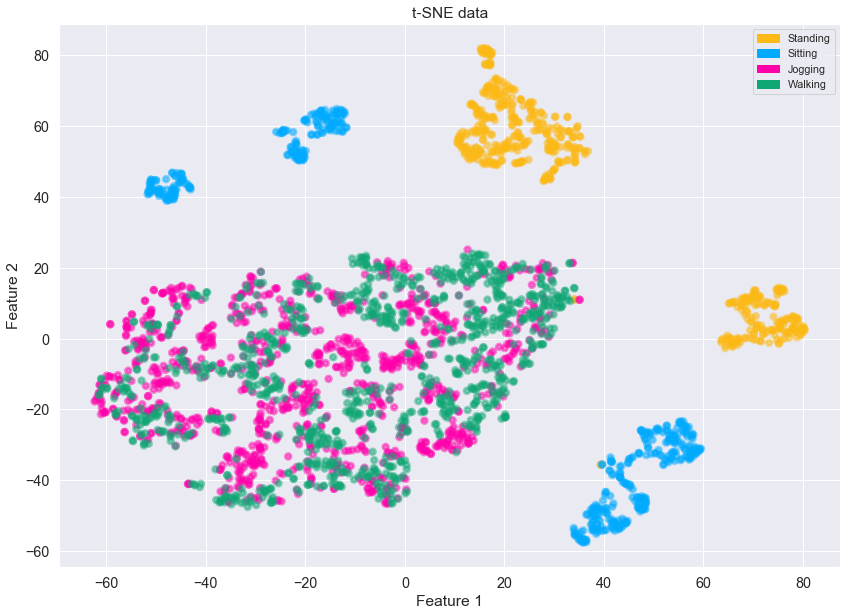

In [21]:
# t-SNE 

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels): 
    num_labels = len(class_labels)
    print(num_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  
    
    colors = ['#fdb915', '#00AAFF', '#FF00AA','#10a674'] 
  
    cmap = ListedColormap(colors) 
    
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(14, 10))
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.45, lw=3)
                #edgecolor='black'
    
    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') 
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('t-SNE data')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) 

n_samples = 300
n_components = 2  
perplexity = 30.0
RS = 1000   

from sklearn.manifold import TSNE
X_tsne = TSNE(random_state=RS, n_components=2, perplexity=30.0, learning_rate=300.0).fit_transform(X_visual)            
plot_labelled_scatter(X_tsne, y_visual,['Standing','Sitting','Jogging','Walking'])